# Image generator

This notebook is used to build the images, charts and graphs in the presentation.

In [1]:
import numpy as np
import skgstat as skg
skg.plotting.backend('plotly')
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

## Overview 

First the Geostatistical software image

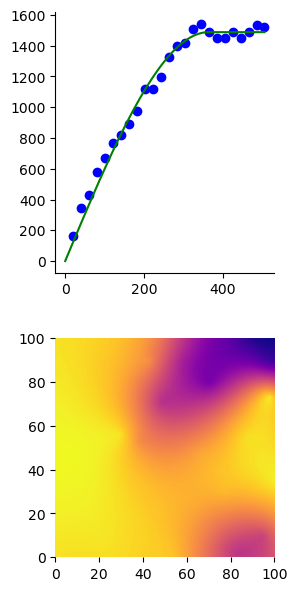

In [5]:
# get the pancake data
coords, vals = skg.data.pancake(N=500).get('sample')
vario = skg.Variogram(coords, vals, normalize=False, maxlag=0.75, n_lags=25)

x = np.linspace(0, vario.bins[-1], 100)
y = vario.fitted_model(x)

krige = vario.to_gs_krige()
field, ss = krige.structured((range(100), range(100)), return_var=True)


fig, axes = plt.subplots(2, 1, figsize=(3, 6.2))
axes[0].plot(vario.bins, vario.experimental, 'bo')
axes[0].plot(x, y, '-g')
axes[1].imshow(field, origin='lower', extent=(0, 100, 0, 100), cmap='plasma')

# remove all spines and axes
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[1].spines['bottom'].set_visible(False)
plt.tight_layout()
fig.savefig('public/img/geostatistical_software.png')

Then, an image illustrating the uncertainty package

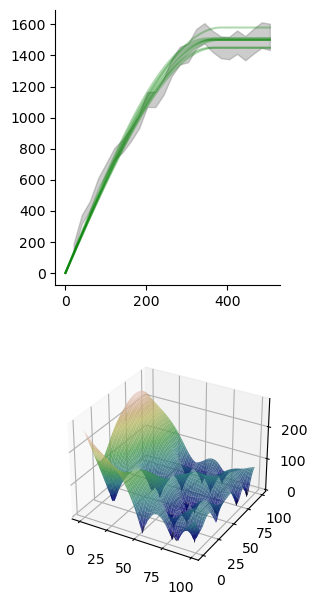

In [6]:
# Make up a random uncertainty band of about 150 units
np.random.seed(42)
lb = vario.experimental - np.random.normal([i *2.5 + 25 for i in range(len(vario.experimental))], scale=0.5)
np.random.seed(44)
ub = vario.experimental + np.random.normal([i *2.5 + 25 for i in range(len(vario.experimental))], scale=0.5)

fig = plt.figure(figsize=(3, 6.2))
ax1 = fig.add_subplot(211)
ax2  = fig.add_subplot(212, projection='3d')

#fig, axes = plt.subplots(2, 1, figsize=(4, 8))
ax1.fill_between(vario.bins, lb, ub, color='gray', alpha=0.4)

# put a few models through the area
x = np.linspace(0, vario.bins[-1], 100)
for r in np.arange(350, 390, 5):
    np.random.seed(r)
    y = skg.models.spherical(x, r, np.random.choice([1450,1490, 1500, 1510, 1550, 1580], 1))
    ax1.plot(x, y, '-g', alpha=0.3)

# create a meshgrid for the field
X, Y = np.meshgrid(range(100), range(100))
ax2.plot_surface(X, Y, ss, cmap='gist_earth', alpha=0.8)

# remove top and right spines
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# remove the spines from the 3d plot
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# save
plt.tight_layout()
fig.savefig('public/img/geostatistical_uncertainty.png')

## Motivation

In [9]:
# fit a gaussian, spheircal and exponential model
vario.model = 'gaussian'
y_gaus = vario.fitted_model(x)
p_gaus = vario.parameters

vario.model = 'exponential'
y_exp = vario.fitted_model(x)
p_exp = vario.parameters

vario.model = 'spherical'
y_sph = vario.fitted_model(x)
p_sph = vario.parameters

# print the vario bins and experimental values to a json file
import json
with open('src/slides/data/vario.json', 'w') as f:
    json.dump({
        'bins': vario.bins.round(1).tolist(),
        'experimental': vario.experimental.round(1).tolist(),
        'modelX': x.round(1).tolist(),
        'modelGauss': y_gaus.round(1).tolist(),
        'modelExp': y_exp.round(1).tolist(),
        'modelSph': y_sph.round(1).tolist(),
        'paramsGauss': p_gaus,
        'paramsExp': p_exp,
        'paramsSph': p_sph,
    }, f, indent=4)

## image samples

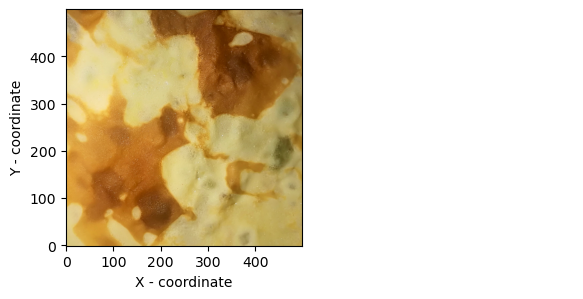

In [88]:
import skgstat as skg
import numpy as np
import matplotlib.pyplot as plt

# get the pancake data
r = skg.data.pancake_field(0).get('sample') 
g = skg.data.pancake_field(1).get('sample')
b = skg.data.pancake_field(2).get('sample')

rgb = np.stack([r, g, b], axis=-1)

fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax2.axis('off')
ax.set_xlabel('X - coordinate')
ax.set_ylabel('Y - coordinate')
ax.imshow(rgb, origin='lower')
plt.tight_layout()
fig.savefig('public/img/pancake_field_rgb.png')

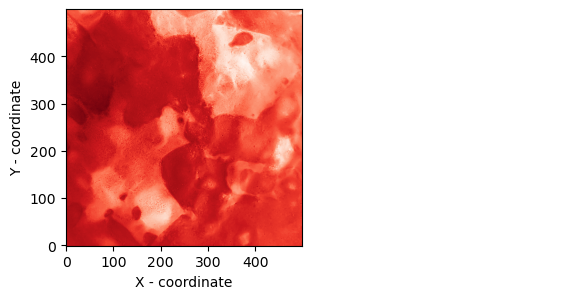

In [87]:
fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax2.axis('off')
ax.imshow(r, cmap='Reds', origin='lower')
ax.set_xlabel('X - coordinate')
ax.set_ylabel('Y - coordinate')
plt.tight_layout()
fig.savefig('public/img/pancake_field_r.png')

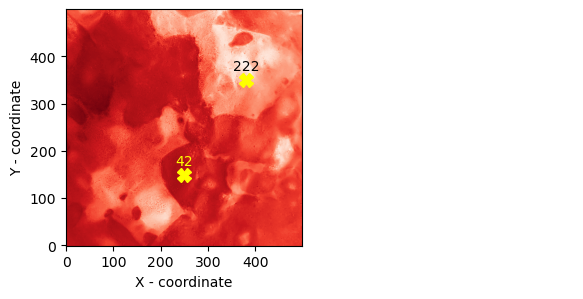

In [89]:
fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax2.axis('off')

ax.imshow(r, cmap='Reds', origin='lower')
ax.set_xlabel('X - coordinate')
ax.set_ylabel('Y - coordinate')

# plot two yellow crosses
ax.plot([250, 380], [150, 350], color='yellow', marker='X', linestyle='None', markersize=10)

# add text labels above the crosses
ax.text(250, 150+28, '42', color='yellow', fontsize=10, ha='center', va='center')
ax.text(380, 350+28, '222', color='black', fontsize=10, ha='center', va='center')

plt.tight_layout()
fig.savefig('public/img/pancake_field_sample.png')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import glob
from itertools import combinations

# sample size
N = 8 

# pre generate the random samples
np.random.seed(42)
xx =  np.random.randint(25, 475, N * 2)
yy =  np.random.randint(25, 475, N * 2)

# make points
points = list(zip(xx, yy))
all_p = list(combinations(points, 2))

# create a GIF of the images
frames = []
all_diffs = []
all_dist = []

#for i,j in zip(range(0, N * 2, 2), range(1, N * 2, 2)):
for i, (p1, p2) in enumerate(all_p):
    # get the two pixel values
    v1 = int(r[p1])
    v2 = int(r[p2])

    # get the differences
    diff = np.abs(v1 - v2)
    all_diffs.append(diff)

    # get the distance
    dist = np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)
    all_dist.append(dist)

    # create a new image for each frame
    fig = plt.figure(figsize=(6, 3))
    ax = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    # plot the image
    m = ax.imshow(r, cmap='Reds', origin='lower')
    ax.set_xlabel('X - coordinate')
    ax.set_ylabel('Y - coordinate')
    ax.plot(xx, yy, color='gray', alpha=0.8, marker='X', markersize=10, linestyle='None')
    ax.plot([p1[0], p2[0]], [p1[1], p2[1]], color='yellow', marker='X', linestyle='--', lw=0.8, markersize=10)
    
    # add text labels above the crosses
    ax.text(p1[0], p1[1] + 28, v1, color='yellow', fontsize=10, ha='center', va='center')
    ax.text(p2[0], p2[1] + 28, v2, color='yellow', fontsize=10, ha='center', va='center')
    
    # create the point cloud
    if i > 0:
        ax2.plot(all_dist[:-1], all_diffs[:-1], color='blue', marker='o', linestyle='None', markersize=5, alpha=0.5)
    ax2.plot(all_dist[-1], all_diffs[-1], color='yellow', marker='o', linestyle='None', markersize=7, alpha=1.0)
    ax2.set_xlabel('Separating distance')
    ax2.set_ylabel('Value difference')
    ax2.set_xlim(0, 450)
    ax2.set_ylim(0, 50)
    plt.tight_layout()
    fig.canvas.draw()

    width, height = fig.get_size_inches() * fig.get_dpi()
    img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    img = img.reshape(int(height), int(width), 3)
    img = Image.fromarray(img)

    # save the image as a frame of the GIF
    img.save(f'frame_{i+1}.png')
    frames.append(Image.open(f'frame_{i+1}.png'))

# save the frames as a GIF
frames[0].save('public/img/pancake_animation.gif', format='GIF', append_images=frames[1:], save_all=True, duration=200, loop=0)

# remove the frames_*.png files
for file in glob.glob('frame_*.png'):
    os.remove(file)